In [81]:
import numpy as np
import sklearn.cluster
import sklearn.mixture
import matplotlib.pyplot as plt
import skimage.feature
import tensorflow.keras as keras
import tensorflow as tf

from sklearn.svm import SVC
from sklearn import cluster
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import KMeans
from sklearn import mixture
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


In [2]:
train_data = np.load('trnImage.npy')
test_data = np.load('tstImage.npy')
train_labels = np.load('trnLabel.npy')
test_labels = np.load('tstLabel.npy')

In [3]:
# Setting feature arrays to zero for train and test respective
train_features = np.zeros((10000,324),dtype = np.float64)
test_features = np.zeros((10000,324),dtype = np.float64)

In [4]:
# Function was taken by the file Runme.ipynb
def computeFeatures(image):
    # This function computes the HOG features with the parsed hyperparameters and returns the features as hog_feature. 
    # By setting visualize=True we obtain an image, hog_as_image, which can be plotted for insight into extracted HOG features.
    hog_feature, hog_as_image = skimage.feature.hog(image, visualize=True, block_norm='L2-Hys')
    return hog_feature, hog_as_image

In [5]:
# Taking the first feature for train and test set
train_features,hog_image =  computeFeatures(train_data[:,:,:,0])
test_features,hog_image = computeFeatures(test_data[:,:,:,0])

In [6]:
for i in range(1,10000):
    feature_i,hog_image_i = computeFeatures(train_data[:,:,:,i])
    train_features = np.vstack((train_features,feature_i))
for i in range(1,1000):
    feature_i_test, hog_image_i = computeFeatures(test_data[:,:,:,i])
    test_features = np.vstack((test_features,feature_i_test))

# Modifing the labels to be 0-9 instead of 1-10
test_labels = test_labels-1
train_labels= train_labels-1

### Unsupervised learning k-means and GMM

In [7]:
# Initializing k-means with 10 clusters as 10 is the number of classes
kmeans = cluster.KMeans(n_clusters=10)
# Fit the model to the data
kmeans.fit(test_features)
# Predict the labels for the train
predictions = kmeans.predict(test_features)
accuracy = np.sum(np.equal(test_labels,predictions.reshape(-1,1)))/test_labels.shape[0]*100
print('Percentage accuracy on testing set is: {0:.2f}%'.format(accuracy))

Percentage accuracy on testing set is: 12.40%


In [8]:
# Because k-means' results were not so good I have chosen random initialize for the centers 
# and increased the iterations of model to 500
gmm = mixture.GaussianMixture(n_components = 10, max_iter=500, init_params="random")
# Using the train set to train our data and trying to predict the test data
gmm.fit(train_features)
gmm_labels = gmm.predict(test_features)
accuracy = np.sum(np.equal(test_labels,gmm_labels.reshape(-1,1)))/test_labels.shape[0]*100
print('Percentage accuracy on testing using gmm set is: {0:.2f}%'.format(accuracy))


Percentage accuracy on testing using gmm set is: 10.90%


### Supervised Learning

Normalize the data so high flactuations will not affect the model significantly

In [9]:
normaliser = StandardScaler().fit(train_features)
train_features = normaliser.transform(train_features)
normaliser = StandardScaler().fit(test_features)
test_features = normaliser.transform(test_features)

Logistic Regression

In [10]:
lgr = LogisticRegression(solver="lbfgs", multi_class="ovr", 
                         max_iter=1000, warm_start = False, C=1) 
# "ovr" also known as One versus Rest will be used in the logistic Regression technique
lgr.fit(train_features,train_labels.ravel())
lgr_predicts = lgr.predict(test_features)
accuracy = np.sum(np.equal(test_labels, lgr_predicts.reshape(-1,1)))/test_labels.shape[0]*100
print('Percentage accuracy on testing set using logistic regression is: {0:.2f}%'.format(accuracy))
print('Explicit Matrix of Predictions')

Percentage accuracy on testing set using logistic regression is: 49.30%
Explicit Matrix of Predictions


Support Vector Machine

In [11]:
svm = SVC(kernel = "poly",C=1) # Polynomial
svm.fit(train_features, train_labels.ravel())
predictions = svm.predict(test_features)
accuracy = np.sum(np.equal(test_labels, predictions.reshape(-1,1)))/test_labels.shape[0]*100
print('Percentage accuracy on testing set using SVM - polynomial kernel is: {0:.2f}%'.format(accuracy))

Percentage accuracy on testing set using SVM - polynomial kernel is: 55.80%


In [12]:
svm = SVC(kernel = "linear",C=1) # linear
svm.fit(train_features, train_labels.ravel())
predictions = svm.predict(test_features)
accuracy = np.sum(np.equal(test_labels, predictions.reshape(-1,1)))/test_labels.shape[0]*100
print('Percentage accuracy on testing set using SVM - linear kernel is: {0:.2f}%'.format(accuracy))

Percentage accuracy on testing set using SVM - linear kernel is: 48.60%


In [13]:
svm = SVC(kernel = "sigmoid",C=1) # sigmoid
svm.fit(train_features, train_labels.ravel())
predictions = svm.predict(test_features)
accuracy = np.sum(np.equal(test_labels, predictions.reshape(-1,1)))/test_labels.shape[0]*100
print('Percentage accuracy on testing set using SVM - sigmoid kernel is: {0:.2f}%'.format(accuracy))

Percentage accuracy on testing set using SVM - sigmoid kernel is: 48.40%


Artificial Neural Network

Neural Network with 1,2 and 3 layers consisted of 10 nodes

In [14]:
model_1 = keras.Sequential()
model_1.add(keras.layers.InputLayer(input_shape=(train_features.shape[1],)))
model_1.add(keras.layers.Dense(10, activation='sigmoid')) # first layer

model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
history = model_1.fit(train_features, train_labels, 
                    validation_data=(test_features, test_labels), epochs=600, verbose=0)
predicted_probabilities = model_1.predict(test_features)
predictions = np.argmax(predicted_probabilities, axis=1)

# Calculate the percentage accuracy rate on test set
accuracy = np.sum(np.equal(test_labels, predictions.reshape(-1,1))) / test_labels.shape[0] * 100
print('Percentage accuracy on testing set using ANN 1-layer is: {0:.2f}%'.format(accuracy))

Percentage accuracy on testing set using ANN 1-layer is: 49.90%


In [15]:
model_2 = keras.Sequential()
model_2.add(keras.layers.InputLayer(input_shape=(train_features.shape[1],)))
model_2.add(keras.layers.Dense(10, activation='sigmoid')) # first layer
model_2.add(keras.layers.Dense(10, activation='sigmoid')) # Second layer
model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
history = model_2.fit(train_features, train_labels, 
                    validation_data=(test_features, test_labels), epochs=600, verbose=0)
predicted_probabilities = model_2.predict(test_features)
predictions = np.argmax(predicted_probabilities, axis=1)

# Calculate the percentage accuracy rate on test set
accuracy = np.sum(np.equal(test_labels, predictions.reshape(-1,1))) / test_labels.shape[0] * 100
print('Percentage accuracy on testing set using ANN - 2 layer is: {0:.2f}%'.format(accuracy))

Percentage accuracy on testing set using ANN - 2 layer is: 45.00%


In [16]:
model_3 = keras.Sequential()
model_3.add(keras.layers.InputLayer(input_shape=(train_features.shape[1],)))
model_3.add(keras.layers.Dense(10, activation='sigmoid')) # first layer
model_3.add(keras.layers.Dense(10, activation='sigmoid')) # Second layer
model_3.add(keras.layers.Dense(10, activation='hard_sigmoid')) # third layer
model_3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
history = model_3.fit(train_features, train_labels, 
                    validation_data=(test_features, test_labels), epochs=600, verbose=0)
predicted_probabilities = model_3.predict(test_features)
predictions = np.argmax(predicted_probabilities, axis=1)

# Calculate the percentage accuracy rate on test set
accuracy = np.sum(np.equal(test_labels, predictions.reshape(-1,1))) / test_labels.shape[0] * 100
print('Percentage accuracy on testing set using ANN - 3 layer is: {0:.2f}%'.format(accuracy))

Percentage accuracy on testing set using ANN - 3 layer is: 42.20%


SGD optimizer for the model with 1 layer 10 nodes

In [17]:
model_ann = keras.Sequential()
model_ann.add(keras.layers.InputLayer(input_shape=(train_features.shape[1],)))
model_ann.add(keras.layers.Dense(10, activation='sigmoid')) # first layer
model_ann.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['acc'])
history = model_ann.fit(train_features, train_labels, 
                    validation_data=(test_features, test_labels), epochs=600, verbose=0)
predicted_probabilities = model_ann.predict(test_features)
predictions = np.argmax(predicted_probabilities, axis=1)

# Calculate the percentage accuracy rate on test set
accuracy = np.sum(np.equal(test_labels, predictions.reshape(-1,1))) / test_labels.shape[0] * 100
print('Percentage accuracy on testing set using ANN is: {0:.2f}%'.format(accuracy))

Percentage accuracy on testing set using ANN is: 50.60%


RMSprop optimizer for the same model

In [18]:
model_rms = keras.Sequential()
model_rms.add(keras.layers.InputLayer(input_shape=(train_features.shape[1],)))
model_rms.add(keras.layers.Dense(10, activation='sigmoid')) # first layer
model_rms.compile(optimizer='RMSprop', loss='sparse_categorical_crossentropy', metrics=['acc'])
history = model_rms.fit(train_features, train_labels, 
                    validation_data=(test_features, test_labels), epochs=600, verbose=0)
predicted_probabilities = model_rms.predict(test_features)
predictions = np.argmax(predicted_probabilities, axis=1)

# Calculate the percentage accuracy rate on test set
accuracy = np.sum(np.equal(test_labels, predictions.reshape(-1,1))) / test_labels.shape[0] * 100
print('Percentage accuracy on testing set using ANN is: {0:.2f}%'.format(accuracy))

Percentage accuracy on testing set using ANN is: 43.80%


### Applying dimensionality reduction (PCA and LDA) and then retrain the models

#### PCA

In [19]:
pca = PCA()
pca.fit(train_features)
pca_train_features = pca.transform(train_features)
pca_test_features = pca.transform(test_features)

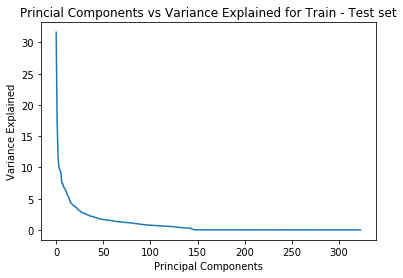

In [20]:
plt.figure()
plt.plot(pca.explained_variance_)
plt.xlabel('Principal Components')
plt.ylabel('Variance Explained')
plt.title('Princial Components vs Variance Explained for Train - Test set')
plt.show()

It is observed that over 140 principal components there is no significant variance that can be explained
Thus, we are going to reapply pca with 140 components 

In [21]:
pca = PCA(n_components=140)
pca.fit(train_features)
pca_train_features = pca.transform(train_features)
pca_test_features = pca.transform(test_features)

### Re-train our models such as Logistic Regression, SVM, and ANN

 Taking the new data set as:
     train = pca_train_features
     test = pca_test_features

Logistic Regression

In [22]:
lgr = LogisticRegression(solver="lbfgs", multi_class="ovr", 
                         max_iter=500, warm_start = False, C=1) 
# "ovr" also known as One versus Rest will be used in the logistic Regression technique
lgr.fit(pca_train_features,train_labels.ravel())
predictions = lgr.predict(pca_test_features)
accuracy = np.sum(np.equal(test_labels, predictions.reshape(-1,1)))/test_labels.shape[0]*100
print('Percentage accuracy on testing set using logistic regression is: {0:.2f}%'.format(accuracy))
print('Explicit Matrix of Predictions')

Percentage accuracy on testing set using logistic regression is: 50.20%
Explicit Matrix of Predictions


Support Vector Machine

In [23]:
# Polynomial kernel had the best performance by now
# Thus we are going to test only on polynomial kernel
clf = SVC(kernel = "poly",C=1, gamma="auto")# Polynomial
clf.fit(pca_train_features, train_labels.ravel())
predictions = clf.predict(pca_test_features)
accuracy = np.sum(np.equal(test_labels, predictions.reshape(-1,1)))/test_labels.shape[0]*100
print('Percentage accuracy on testing set using SVM - polynomial kernel is: {0:.2f}%'.format(accuracy))

Percentage accuracy on testing set using SVM - polynomial kernel is: 59.30%


Artificial Neural Network with Sgd solver 1 layer with 10 nodes and Sigmoid as activation function

In [24]:
model = keras.Sequential()
model.add(keras.layers.InputLayer(input_shape=(pca_train_features.shape[1],)))
model.add(keras.layers.Dense(10, activation='sigmoid')) # first layer
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['acc'])
history = model.fit(pca_train_features, train_labels, 
                    validation_data=(pca_test_features, test_labels), epochs=600, verbose=0)
predicted_probabilities = model.predict(pca_test_features)
predictions = np.argmax(predicted_probabilities, axis=1)

# Calculate the percentage accuracy rate on test set
accuracy = np.sum(np.equal(test_labels, predictions.reshape(-1,1))) / test_labels.shape[0] * 100
print('Percentage accuracy on testing set using ANN is: {0:.2f}%'.format(accuracy))

Percentage accuracy on testing set using ANN is: 50.00%


#### Perfoming LDA to the dataset

Text(0.5, 1.0, 'Principal Components vs Variance Explained using LDA')

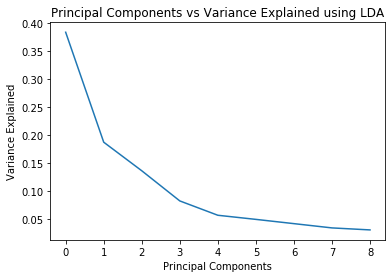

In [25]:
lda = LinearDiscriminantAnalysis()
lda.fit(train_features, train_labels.ravel())

plt.plot(lda.explained_variance_ratio_)
plt.xlabel('Principal Components')
plt.ylabel('Variance Explained')
plt.title('Principal Components vs Variance Explained using LDA')

We dont need to do a trade-off between complexity and accuracy as there are only 9 principal components

In [26]:
# We are going to use all the components as the complexity is not high enough
lda = LinearDiscriminantAnalysis(n_components=9)
lda.fit(train_features, train_labels.ravel())
lda_train_features = lda.transform(train_features)
lda_test_features = lda.transform(test_features)

#### Re-applying everything on LDA set

In [27]:
# Logistic Regression
lgr = LogisticRegression(solver="lbfgs", multi_class="ovr", 
                         max_iter=500, warm_start = False, C=1) 
# "ovr" also known as One versus Rest will be used in the logistic Regression technique
lgr.fit(lda_train_features,train_labels.ravel())
predictions = lgr.predict(lda_test_features)
accuracy = np.sum(np.equal(test_labels, predictions.reshape(-1,1)))/test_labels.shape[0]*100
print('Percentage accuracy on testing set using logistic regression on LDA set is: {0:.2f}%'.format(accuracy))

Percentage accuracy on testing set using logistic regression on LDA set is: 49.10%


In [28]:
# SVM
# Polynomial kernel had the best performance by now
# Thus we are going to test only on polynomial kernel
svm = SVC(kernel = "poly",C=1, gamma="auto")# Polynomial
svm.fit(lda_train_features, train_labels.ravel())
predictions = svm.predict(lda_test_features)
accuracy = np.sum(np.equal(test_labels, predictions.reshape(-1,1)))/test_labels.shape[0]*100
print('Percentage accuracy on testing set using SVM on LDA set is: {0:.2f}%'.format(accuracy))

Percentage accuracy on testing set using SVM on LDA set is: 49.10%


In [29]:
model = keras.Sequential()
model.add(keras.layers.InputLayer(input_shape=(lda_train_features.shape[1],)))
model.add(keras.layers.Dense(10, activation='sigmoid')) # first layer
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['acc'])
history = model.fit(lda_train_features, train_labels, 
                    validation_data=(lda_test_features, test_labels), epochs=600, verbose=0)
predicted_probabilities = model.predict(lda_test_features)
predictions = np.argmax(predicted_probabilities, axis=1)

# Calculate the percentage accuracy rate on test set
accuracy = np.sum(np.equal(test_labels, predictions.reshape(-1,1))) / test_labels.shape[0] * 100
print('Percentage accuracy on testing set using ANN on LDA set is: {0:.2f}%'.format(accuracy))

Percentage accuracy on testing set using ANN on LDA set is: 49.80%


#### Combining LDA and PCA features to one dataset and re-applying the algorithms

In [30]:
new_train_features = np.hstack((pca_train_features,lda_train_features))
new_test_features = np.hstack((pca_test_features, lda_test_features))

In [31]:
# Logistic Regression
lgr = LogisticRegression(solver="lbfgs", multi_class="ovr", 
                         max_iter=500, warm_start = False, C=1) 
# "ovr" also known as One versus Rest will be used in the logistic Regression technique
lgr.fit(new_train_features,train_labels.ravel())
predictions = lgr.predict(new_test_features)
accuracy = np.sum(np.equal(test_labels, predictions.reshape(-1,1)))/test_labels.shape[0]*100
print('Percentage accuracy on testing set using logistic regression LDA+PCA set is: {0:.2f}%'.format(accuracy))

Percentage accuracy on testing set using logistic regression LDA+PCA set is: 48.70%


In [32]:
# SVM
svm = SVC(kernel = "poly",C=1, gamma="auto")# Polynomial
svm.fit(new_train_features, train_labels.ravel())
predictions = svm.predict(new_test_features)
accuracy = np.sum(np.equal(test_labels, predictions.reshape(-1,1)))/test_labels.shape[0]*100
print('Percentage accuracy on testing set using SVM - LDA+PCA set is: {0:.2f}%'.format(accuracy))

Percentage accuracy on testing set using SVM - LDA+PCA set is: 59.80%


In [33]:
# ANN
model = keras.Sequential()
model.add(keras.layers.InputLayer(input_shape=(new_train_features.shape[1],)))
model.add(keras.layers.Dense(10, activation='sigmoid')) # first layer
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['acc'])
history = model.fit(new_train_features, train_labels, 
                    validation_data=(new_test_features, test_labels), epochs=600, verbose=0)
predicted_probabilities = model.predict(new_test_features)
predictions = np.argmax(predicted_probabilities, axis=1)

# Calculate the percentage accuracy rate on test set
accuracy = np.sum(np.equal(test_labels, predictions.reshape(-1,1))) / test_labels.shape[0] * 100
print('Percentage accuracy on testing set using ANN - LDA+PCA set is: {0:.2f}%'.format(accuracy))

Percentage accuracy on testing set using ANN - LDA+PCA set is: 50.60%


By now, SVM seems to perform better than any model we created.
Now we will extract extra features from the original dataset by rotating images by 90,180 and 270 degrees
Afterwards, PCA and LDA will be performed on the new 10000, 3*324 dataset and will feed the models again
To see if we can have better performance

#### rotate by 90 degrees

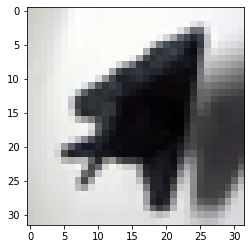

In [34]:
tempo_array = np.rot90(train_data[:,:,:,0])
rot90_train_features,hog_image = computeFeatures(tempo_array)
plt.imshow(tempo_array)

tempo_array = np.rot90(test_data[:,:,:,0])
rot90_test_features,hog_image = computeFeatures(tempo_array)

In [35]:
for i in range(1,10000):
    tempo_array = np.rot90(train_data[:,:,:,i])
    feature,image = computeFeatures(tempo_array)
    rot90_train_features = np.vstack((rot90_train_features, feature))
for i in range(1,1000):
    tempo_array = np.rot90(test_data[:,:,:,i])
    feature,image = computeFeatures(tempo_array)
    rot90_test_features = np.vstack((rot90_test_features, feature))


#### rotate by 180 degrees

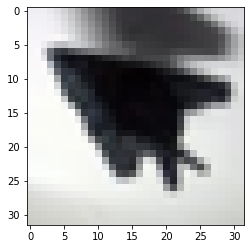

In [36]:
tempo_array = np.rot90(train_data[:,:,:,0])
tempo_array = np.rot90(tempo_array)
rot180_train_features,hog_image = computeFeatures(tempo_array)
plt.imshow(tempo_array)

tempo_array = np.rot90(test_data[:,:,:,0])
tempo_array = np.rot90(tempo_array)
rot180_test_features,hog_image = computeFeatures(tempo_array)

In [37]:
for i in range(1,10000):
    tempo_array = np.rot90(train_data[:,:,:,i])
    tempo_array = np.rot90(tempo_array)
    feature,image = computeFeatures(tempo_array)
    rot180_train_features = np.vstack((rot180_train_features, feature))
for i in range(1,1000):
    tempo_array = np.rot90(test_data[:,:,:,i])
    tempo_array = np.rot90(tempo_array)
    feature,image = computeFeatures(tempo_array)
    rot180_test_features = np.vstack((rot180_test_features, feature))


#### rotate by 270 degrees

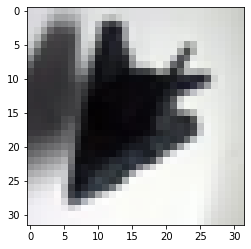

In [38]:
tempo_array = np.rot90(train_data[:,:,:,0])
tempo_array = np.rot90(tempo_array)
tempo_array = np.rot90(tempo_array)
plt.imshow(tempo_array)

rot270_train_features,hog_image = computeFeatures(tempo_array)

tempo_array = np.rot90(test_data[:,:,:,0])
tempo_array = np.rot90(tempo_array)
tempo_array = np.rot90(tempo_array)
rot270_test_features,hog_image = computeFeatures(tempo_array)

In [39]:
for i in range(1,10000):
    tempo_array = np.rot90(train_data[:,:,:,i])
    tempo_array = np.rot90(tempo_array)
    tempo_array = np.rot90(tempo_array)
    feature,image = computeFeatures(tempo_array)
    rot270_train_features = np.vstack((rot270_train_features, feature))
for i in range(1,1000):
    tempo_array = np.rot90(test_data[:,:,:,i])
    tempo_array = np.rot90(tempo_array)
    tempo_array = np.rot90(tempo_array)
    feature,image = computeFeatures(tempo_array)
    rot270_test_features = np.vstack((rot270_test_features, feature))


In [40]:
rot_train_features = np.hstack((train_features, rot90_train_features,
                               rot180_train_features, rot270_train_features))
rot_test_features = np.hstack((test_features, rot90_test_features,
                              rot180_test_features, rot270_test_features))

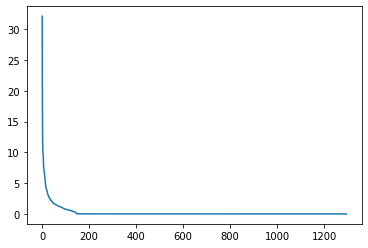

In [41]:
pca = PCA()
pca.fit(rot_train_features)

plt.plot(pca.explained_variance_)

In [42]:
pca = PCA(n_components = 140)
pca.fit(rot_train_features)
new_rot_train_features = pca.transform(rot_train_features)
new_rot_test_features = pca.transform(rot_test_features)

In [43]:
# Logistic Regression
lgr = LogisticRegression(solver="lbfgs", multi_class="ovr", 
                         max_iter=500, warm_start = False, C=1) 
# "ovr" also known as One versus Rest will be used in the logistic Regression technique
lgr.fit(new_rot_train_features,train_labels.ravel())
predictions = lgr.predict(new_rot_test_features)
accuracy = np.sum(np.equal(test_labels, predictions.reshape(-1,1)))/test_labels.shape[0]*100
print('Percentage accuracy on testing set using logistic regression is: {0:.2f}%'.format(accuracy))

Percentage accuracy on testing set using logistic regression is: 50.30%


In [44]:
#SVM
svm = SVC(kernel = "poly",C=1, gamma="auto")# Polynomial
svm.fit(new_rot_train_features, train_labels.ravel())
predictions = svm.predict(new_rot_test_features)
accuracy = np.sum(np.equal(test_labels, predictions.reshape(-1,1)))/test_labels.shape[0]*100
print('Percentage accuracy on testing set using SVM - polynomial kernel is: {0:.2f}%'.format(accuracy))

Percentage accuracy on testing set using SVM - polynomial kernel is: 59.30%


In [45]:
# applying LDA and Merge with PCA dataset
lda = LinearDiscriminantAnalysis(n_components = 9)
lda.fit(rot_train_features, train_labels.ravel())

c:\users\thomas\appdata\local\programs\python\python37\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LinearDiscriminantAnalysis(n_components=9, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

We expected some colinearity as those share same features for the biggest proportion of them

In [46]:
new_rot_train_features = np.hstack((new_rot_train_features ,lda.transform(rot_train_features)))
new_rot_test_features = np.hstack((new_rot_test_features, lda.transform(rot_test_features)))

In [47]:
#SVM
svm = SVC(kernel = "poly",C=1, gamma="auto")# Polynomial
svm.fit(new_rot_train_features, train_labels.ravel())
predictions = svm.predict(new_rot_test_features)
accuracy = np.sum(np.equal(test_labels, predictions.reshape(-1,1)))/test_labels.shape[0]*100
print('Percentage accuracy on testing set using SVM new set is: {0:.2f}%'.format(accuracy))

Percentage accuracy on testing set using SVM new set is: 59.50%


In [48]:
# Logistic Regression
lgr = LogisticRegression(solver="lbfgs", multi_class="ovr", 
                         max_iter=500, warm_start = False, C=1) 
# "ovr" also known as One versus Rest will be used in the logistic Regression technique
lgr.fit(new_rot_train_features,train_labels.ravel())
predictions = lgr.predict(new_rot_test_features)
accuracy = np.sum(np.equal(test_labels, predictions.reshape(-1,1)))/test_labels.shape[0]*100
print('Percentage accuracy on testing set using logistic regression new set is: {0:.2f}%'.format(accuracy))

Percentage accuracy on testing set using logistic regression new set is: 48.60%


In [49]:
# ANN
model = keras.Sequential()
model.add(keras.layers.InputLayer(input_shape=(new_rot_train_features.shape[1],)))
model.add(keras.layers.Dense(10, activation='sigmoid')) # first layer
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['acc'])
history = model.fit(new_rot_train_features, train_labels, 
                    validation_data=(new_rot_test_features, test_labels), epochs=600, verbose=0)
predicted_probabilities = model.predict(new_rot_test_features)
predictions = np.argmax(predicted_probabilities, axis=1)

# Calculate the percentage accuracy rate on test set
accuracy = np.sum(np.equal(test_labels, predictions.reshape(-1,1))) / test_labels.shape[0] * 100
print('Percentage accuracy on testing set using ANN on new set is: {0:.2f}%'.format(accuracy))

Percentage accuracy on testing set using ANN on new set is: 48.30%


#### Final Model
The final model will be SVM which has as a training set 140 principal components for the extracted features by using PCA. The model will consist of a polynomial kernel with C=1, and gamma="auto". By this way the 59.8% is being achieved as the highest accuracy by now.



In [53]:
#Final Model
final_model = SVC(kernel = "poly",C=1, gamma="auto")# Polynomial
final_model.fit(new_train_features, train_labels.ravel())
predictions = final_model.predict(new_test_features)
accuracy = np.sum(np.equal(test_labels, predictions.reshape(-1,1)))/test_labels.shape[0]*100
print('Percentage accuracy on testing set using SVM - LDA+PCA set is: {0:.2f}%'.format(accuracy))

Percentage accuracy on testing set using SVM - LDA+PCA set is: 59.80%
              precision    recall  f1-score   support

    airplane       0.70      0.57      0.63       100
  automobile       0.71      0.72      0.71       100
        bird       0.51      0.42      0.46       100
         cat       0.56      0.35      0.43       100
        deer       0.45      0.73      0.55       100
         dog       0.53      0.52      0.53       100
        frog       0.57      0.73      0.64       100
       horse       0.71      0.63      0.67       100
        ship       0.65      0.65      0.65       100
      truck        0.70      0.66      0.68       100

    accuracy                           0.60      1000
   macro avg       0.61      0.60      0.60      1000
weighted avg       0.61      0.60      0.60      1000

The confusion Matrix for the final model is: 

[[57  2  5  2  7  2  5  4 14  2]
 [ 2 72  0  0  5  1  3  1  9  7]
 [ 5  1 42  4  8 15 16  4  2  3]
 [ 0  3 12 35 16 15 11  5

##### Confusion Matrix and Classification Report
Below we can see the classification report, TP ratio, FP ration and the average accuracy of the model in general. Also the explicit confusion matrix is given below.

In [59]:
label_names = ['airplane', 'automobile', 'bird',
              'cat', 'deer', 'dog', 'frog', 'horse',
              'ship', 'truck ']
print(classification_report(test_labels, predictions, target_names=label_names))
print('The confusion Matrix for the final model is: \n')
print(confusion_matrix(test_labels, predictions))

              precision    recall  f1-score   support

    airplane       0.70      0.57      0.63       100
  automobile       0.71      0.72      0.71       100
        bird       0.51      0.42      0.46       100
         cat       0.56      0.35      0.43       100
        deer       0.45      0.73      0.55       100
         dog       0.53      0.52      0.53       100
        frog       0.57      0.73      0.64       100
       horse       0.71      0.63      0.67       100
        ship       0.65      0.65      0.65       100
      truck        0.70      0.66      0.68       100

    accuracy                           0.60      1000
   macro avg       0.61      0.60      0.60      1000
weighted avg       0.61      0.60      0.60      1000

The confusion Matrix for the final model is: 

[[57  2  5  2  7  2  5  4 14  2]
 [ 2 72  0  0  5  1  3  1  9  7]
 [ 5  1 42  4  8 15 16  4  2  3]
 [ 0  3 12 35 16 15 11  5  0  3]
 [ 1  1  6  5 73  2  8  1  2  1]
 [ 0  2  6  8 17 52  7  7  1 

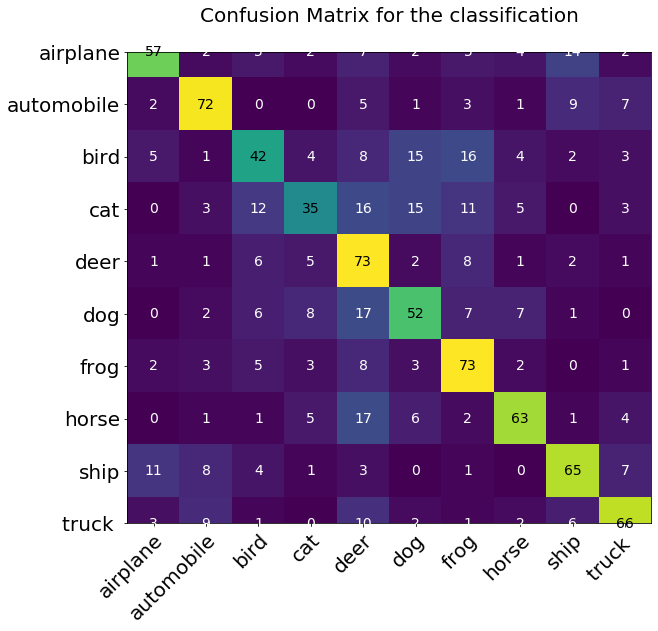

In [111]:
# The above code was adapted based on the code on Matplotlib official page - tutorial for heatmaps
# The original code can be found here: 
# https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html

import pandas as pd
conf_matrix = confusion_matrix(test_labels, predictions)

fig, ax = plt.subplots(figsize = (9,9))
im = ax.imshow(conf_matrix)

ax.set_xticks(np.arange(len(label_names)))
ax.set_yticks(np.arange(len(label_names)))

ax.set_xticklabels(label_names, size=20)
ax.set_yticklabels(label_names, size=20)

# Loop over data dimensions and create text annotations.
for i in range(len(label_names)):
    for j in range(len(label_names)):
        if(i == j):
            text = ax.text(j, i, conf_matrix[i, j],
                       ha="center", va="center", color="black", size=14)
        else:
            text = ax.text(j, i, conf_matrix[i, j],
                       ha="center", va="center", color="white", size=14)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


ax.set_title("Confusion Matrix for the classification", pad= 30, size = 20)
fig.tight_layout(pad=0.2)
plt.show()

#### Suggestions

We propose a suggestion for a potential better improvement over here.
We see that animals are barely misclassified as objects (truck, automobile etc.). Thus, we propose to intoduce a new label for the original set. Train one model to predict the labels as "animal" and "object"
and if the accuracy is high enough based on that predictions re-train another model that uses those labels
to predict which class belongs any of those. We tend to believe that this action would improve the original accuracy significantly.